1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normal
distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
   * $x_1$ is distributed as $N(0,1)$
   * $x_2$ is distributed as $x_1+N(0,3)$
   * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset
was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of
the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordinates as a set of scatter plots.
Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


---Data set---
x = array([[ 0.93515616, -0.12921518, -0.34855835, ..., -0.67543969,
         0.67991336,  0.8054994 ],
       [ 3.26640134,  2.10278817, -0.72647082, ...,  0.45924588,
        -0.82287564,  1.00553682],
       [ 5.13671366,  1.84435782, -1.42358751, ..., -0.89163349,
         0.53695109,  2.61653563]])
x.shape = (3, 1000)

---Covariance---
x_cov = array([[ 1.068677  ,  1.15267457,  3.29002858],
       [ 1.15267457, 10.42856987, 12.73391901],
       [ 3.29002858, 12.73391901, 19.31397617]])

---Direct eigenvalues---
eigenvalues = array([ 2.87636122e+01,  2.04761086e+00, -4.26770849e-15])
eigenvectors = array([[-0.12022276,  0.56469445, -0.81649658],
       [-0.57138387, -0.71193666, -0.40824829],
       [-0.81182939,  0.41745224,  0.40824829]])

---SVD for eigenvalues---
u = array([[-0.12022276,  0.56469445, -0.81649658],
       [-0.57138387, -0.71193666, -0.40824829],
       [-0.81182939,  0.41745224,  0.40824829]])
spectrum = array([2.87636122e+01, 2.04761086e+00, 9.7

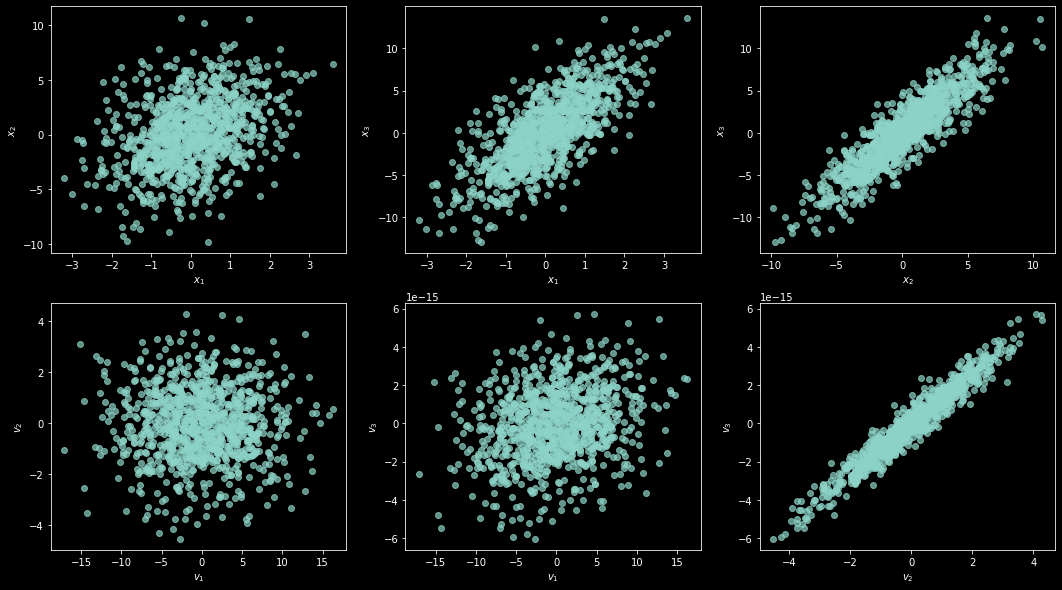

In [2]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
plt.style.use("dark_background")

#
sample_size = 1000
x1 = np.random.normal(0.0, 1.0, size=sample_size)
x2 = x1 + np.random.normal(0.0, 3.0, size=sample_size)
x3 = 2 * x1 + x2
x = np.vstack((x1, x2, x3))
print()
print("---Data set---")
print(f"{x = }")
print(f"{x.shape = }")
print()
print("---Covariance---")
#
x_cov = np.cov(x)
print(f"{x_cov = }")
print()
print("---Direct eigenvalues---")
eigenvalues, eigenvectors = la.eig(x_cov)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
print(f"{eigenvalues = }")
print(f"{eigenvectors = }")
print()
print("---SVD for eigenvalues---")
u, spectrum, v = la.svd(x_cov)
print(f"{u = }")
print(f"{spectrum = }")
print()
#
print("---PCA---")
cov_trace = x_cov.trace()
print(f"{cov_trace = :.16f}")
print(f"{eigenvalues[0] = :.16f}")
print(f"{eigenvalues[1] = :.16f}")
print(f"{eigenvalues[2] = :.16f}")
print(f"Just with {eigenvalues[0]:.2f} and {eigenvalues[1]:.2f}"
      f" we explain pretty much all of the cov trace.")
print("This is to be expected, as the third variable was just a linear combination of the other two.")
print()
#
print("---Dimensionality Reduction---")
# We could also consider that the projection of the data onto the span of the first two eigenvectors leaves it invariant
#span = np.array((eigenvectors[:, 0], eigenvectors[:, 1])).transpose()
#proyector = np.matmul(span, la.inv(np.matmul(span.T, span)))
#proyector = np.matmul(proyector, span.T)
#print(f"{proyector = }")
#x_redux = np.matmul(proyector, x)
x_redux = np.matmul(la.inv(u), x)
print()
#
fig, axs = plt.subplots(2, 3, figsize=(18, 10))
axs[0, 0].scatter(x[0], x[1], alpha=0.7)
axs[0, 0].set(xlabel='$x_1$', ylabel="$x_2$")
axs[0, 1].scatter(x[0], x[2], alpha=0.7)
axs[0, 1].set(xlabel='$x_1$', ylabel="$x_3$")
axs[0, 2].scatter(x[1], x[2], alpha=0.7)
axs[0, 2].set(xlabel='$x_2$', ylabel="$x_3$")
axs[1, 0].scatter(x_redux[0], x_redux[1], alpha=0.7)
axs[1, 0].set(xlabel='$v_1$', ylabel="$v_2$")
axs[1, 1].scatter(x_redux[0], x_redux[2], alpha=0.7)
axs[1, 1].set(xlabel='$v_1$', ylabel="$v_3$")
axs[1, 2].scatter(x_redux[1], x_redux[2], alpha=0.7)
axs[1, 2].set(xlabel='$v_2$', ylabel="$v_3$")
plt.show()

This result makes sense, because the dimensionality reduction is just noticing that in the eigenvector basis, we only
need to consider some directions to account for the vast majority of the dispersion.

We see this is the case here: for the last two columns (third eigenvector), the dispersion of the scatter points in the bottom row
is a factor of $10^{-15}$ smaller than along the other two eigenvectors, so we can discard it without much loss.

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise.
Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar
deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [5]:
x_noise = np.random.normal(0.0, 1.0 / 50.0, size=(10, sample_size))
x = np.vstack((x, x_noise))
x_cov = np.cov(x)
u, spectrum, v = la.svd(x_cov)
diag = np.diag(spectrum)
cov_trace = x_cov.trace()
print("---PCA---")
print(f"{cov_trace = :.4f}")
print(f"We see that {spectrum[0]:.4f} and {spectrum[1]:.4f} amount for"
      f" {100 * (spectrum[0] + spectrum[1])/cov_trace:.4f}%"
      f" of the cov trace.")
print()
print("---Dimensionality Reduction---")
# We could also consider that the projection of the data onto the span of the first two eigenvectors leaves it invariant
#span = np.array((u[:, 0], u[:, 1])).transpose()
#proyector = np.matmul(span, la.inv(np.matmul(span.T, span)))
#proyector = np.matmul(proyector, span.T)
#print(f"{proyector.shape = }")
#x_redux = np.matmul(proyector, x)
x_redux = np.matmul(la.inv(u), x)
print()

---PCA---
cov_trace = 29.5284
We see that 27.4571 and 2.0673 amount for 99.9864% of the cov trace.

---Dimensionality Reduction---
proyector.shape = (13, 13)



3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record
the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$,
the angles in spherical coordinates.

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the X axis,
assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate
the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding
the only one coordinate that really matters.

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [6]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

zsh:1: command not found: wget
zsh:1: command not found: wget
